In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
!pip install pydicom
from pydicom import dcmread
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torch.utils import data

## Data Preprocessing

In [2]:
data = pd.read_csv('stage_2_train_labels.csv').filter(['patientId', 'Target'])
data.head(5)

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [3]:
train_labels, val_labels = train_test_split(data.values, test_size=0.1)
print(train_labels.shape)
print(val_labels.shape)

(27204, 2)
(3023, 2)


In [ ]:
train_paths = [os.path.join('stage_2_train_images', image[0]) for image in train_labels]
val_paths = [os.path.join('stage_2_test_images', image[0]) for image in val_labels]

## Data Samples

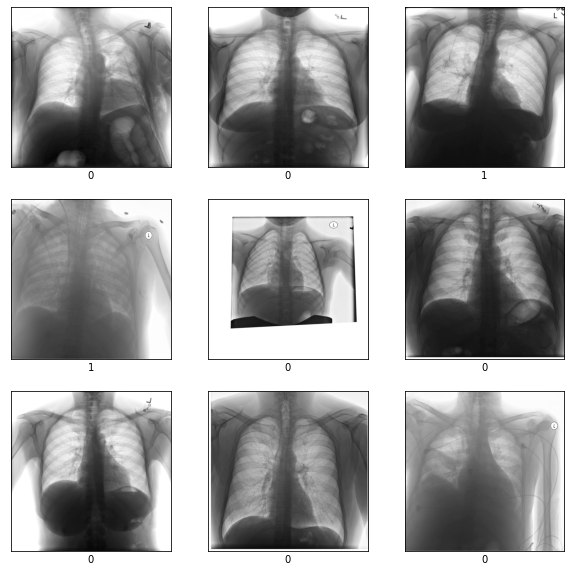

In [6]:
def show(n=9):
    plt.figure(figsize=(10,10))
    for i in range(n):
        plt.xticks([])
        plt.yticks([])
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        img_dcm = dcmread(f'{train_paths[i+20]}.dcm')
        plt.imshow(img_dcm.pixel_array, cmap=plt.cm.binary)
        plt.xlabel(train_labels[i+20][1])
show()

## Composing transformations

In [7]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor()])

## Formatted Dataset 

In [8]:
class Dataset(data.Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self, index):
        image = dcmread(f'{self.paths[index]}.dcm')
        image = image.pixel_array
        image = image / 255.0
        image = (255*image).clip(0, 255).astype(np.uint8)
        image = Image.fromarray(image).convert('RGB')
        label = self.labels[index][1]
        if self.transform is not None:
            image = self.transform(image)
        return image, label
        
    def __len__(self):
        return len(self.paths)

Tensor:tensor([[[0.0118, 0.0118, 0.0118,  ..., 0.0549, 0.0745, 0.0235],
         [0.0157, 0.0118, 0.0118,  ..., 0.0549, 0.0784, 0.0275],
         [0.0157, 0.0118, 0.0118,  ..., 0.0510, 0.0706, 0.0235],
         ...,
         [0.0784, 0.0784, 0.0745,  ..., 0.0980, 0.0941, 0.0275],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0118, 0.0118, 0.0118,  ..., 0.0549, 0.0745, 0.0235],
         [0.0157, 0.0118, 0.0118,  ..., 0.0549, 0.0784, 0.0275],
         [0.0157, 0.0118, 0.0118,  ..., 0.0510, 0.0706, 0.0235],
         ...,
         [0.0784, 0.0784, 0.0745,  ..., 0.0980, 0.0941, 0.0275],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0118, 0.0118, 0.0118,  ..., 0.0549, 0.0745, 0.0235],
         [0.0157, 0.0118, 0.0118,  ..., 0.0549, 0.0784, 0.0275],
         [0.0157, 0.0118, 0.0118,  ..., 0.0510, 0.0

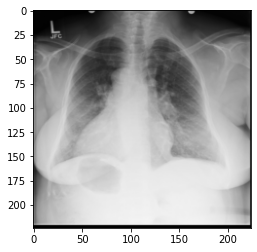

In [9]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
image = iter(train_dataset)
img, label = next(image)
print(f'Tensor:{img}, Label:{label}')
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)

## Train image shape

In [10]:
img.shape

torch.Size([224, 224, 3])

## Load Training and Testing Dataset

In [11]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
val_dataset = Dataset(val_paths, val_labels, transform=transform)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=8, shuffle=False)

## Check dataloader

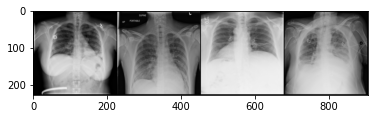

In [12]:
batch = iter(train_loader)
images, labels = next(batch)

image_grid = torchvision.utils.make_grid(images[:4])
image_np = image_grid.numpy()
img = np.transpose(image_np, (1, 2, 0))
plt.imshow(img)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
device

device(type='cuda')

## Load pre-trained ResNet18 and fine-tune

In [15]:
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 2)

model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [16]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Write a train code and RUN

In [17]:
torch.cuda.empty_cache()
# Train the model
total_step = len(train_loader)
for epoch in range(10):
    # Training
    for i, (images, labels) in tqdm(enumerate(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 2000 == 0:
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))


    # Validation
    correct = 0
    total = 0  
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum()
    print(f'Epoch: {epoch+1}/{num_epochs}, Val_Acc: {100*correct/total}')

2001it [04:22,  7.34it/s]

Epoch [1/10], Step [2000/3401], Loss: 0.5250


3401it [07:22,  7.68it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:45<00:00,  8.29it/s]


Epoch: 1/10, Val_Acc: 82.00463104248047


2001it [04:20,  7.45it/s]

Epoch [2/10], Step [2000/3401], Loss: 0.5152


3401it [07:22,  7.68it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:46<00:00,  8.10it/s]


Epoch: 2/10, Val_Acc: 82.56698608398438


2001it [04:06,  7.64it/s]

Epoch [3/10], Step [2000/3401], Loss: 0.2324


3401it [07:00,  8.10it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:45<00:00,  8.36it/s]


Epoch: 3/10, Val_Acc: 82.96394348144531


2001it [04:03,  7.79it/s]

Epoch [4/10], Step [2000/3401], Loss: 0.9489


3401it [06:57,  8.14it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:43<00:00,  8.69it/s]


Epoch: 4/10, Val_Acc: 82.86470031738281


2001it [04:03,  7.79it/s]

Epoch [5/10], Step [2000/3401], Loss: 0.1285


3401it [06:56,  8.16it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:42<00:00,  8.80it/s]


Epoch: 5/10, Val_Acc: 83.32781982421875


2001it [04:20,  6.95it/s]

Epoch [6/10], Step [2000/3401], Loss: 0.1701


3401it [07:32,  7.51it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:48<00:00,  7.77it/s]


Epoch: 6/10, Val_Acc: 83.85709381103516


2001it [04:33,  7.10it/s]

Epoch [7/10], Step [2000/3401], Loss: 0.3020


3401it [07:48,  7.26it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:53<00:00,  7.04it/s]


Epoch: 7/10, Val_Acc: 83.09626007080078


2001it [04:59,  6.15it/s]

Epoch [8/10], Step [2000/3401], Loss: 0.1471


3401it [08:57,  6.33it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:55<00:00,  6.82it/s]


Epoch: 8/10, Val_Acc: 83.79093933105469


2001it [04:55,  5.27it/s]

Epoch [9/10], Step [2000/3401], Loss: 0.4544


3401it [09:22,  6.05it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [01:16<00:00,  4.91it/s]


Epoch: 9/10, Val_Acc: 85.3456802368164


2001it [05:51,  6.13it/s]

Epoch [10/10], Step [2000/3401], Loss: 0.1801


3401it [09:26,  6.00it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [01:17<00:00,  4.86it/s]


Epoch: 10/10, Val_Acc: 84.48561096191406


In [18]:
torch.save(model.state_dict(), "resNet18.pt")

In [19]:
resnet = torchvision.models.resnet18()
n = resnet.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet.fc = nn.Linear(n, 2)
resnet.to(device)
resnet.load_state_dict(torch.load("resNet18.pt"))

<All keys matched successfully>

In [20]:
print(torch.__version__)

1.11.0+cu113


## Test model

In [22]:
resnet.eval()
preds = []
labels = []
with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.max(resnet(data),1)[1].item()
        preds.append(pred)
        labels.append(label)

100%|███████████████████████████████████████████████████████████████████████████████| 3023/3023 [01:13<00:00, 41.27it/s]


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
acc = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)
cm = confusion_matrix(labels, preds)

print(f"Val Accuracy {acc}")
print(f"Val precision {precision}")
print(f"Val Recall {recall}")
print(f"Val F1 {f1}")
print(f"Confusion Matrix {cm}")

Val Accuracy 0.8418789282170029
Val precision 0.7396335583413693
Val Recall 0.7866666666666666
Val F1 0.7624254473161034
Confusion Matrix [[1778  270]
 [ 208  767]]
